# AI Image Classifier

Made by <a href="https://github.com/SeanvonB">SeanvonB</a> | <a href="https://github.com/SeanvonB/image-classifier">Source</a>

This was the final project of my AI Programming Nanodegree from Udacity, which I completed work on in 2019. The purpose of this project was to train an image classifier for use in a hypothetical smart phone app – in our case, an app that could identify the name of a flower simply by looking at it with the phone's camera. For the purpose of training such a network, we were given the [102 Category Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from the University of Oxford's Visual Geometry Group, or VGG, which contains between 40 and 258 images for each of the 102 categories. Here are a few example of these images and their associated class-to-name identities:

<img src='images/flower.png' width="100%" height="auto" style="max-width: 800px;">

Per Udacity's instruction, the project was broken down into three steps:

* Loading and preprocessing the dataset images
* Training the image classifier network on processed dataset
* Using the trained classifier to predict image content

It's also worth mentioning that this project uses flowers as an example, but the model could theoretically classify images according to any dataset that can be made available to it. Replace the data folder with VGG's [Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) and tweak a couple links, re-run the training cycle, then – bam! – this project becomes a pet breed classifier!

### Loading Packages

This project uses PyTorch plus Torchvision and PIL to preprocess images, assemble the model architecture, and train the network. It also relies on MatPlotLib to present data and NumPy for matrix multiplication.

The training cycles will default to CUDA for GPU training when available. With CUDA, the network can reach passable accuracy in about an hour; without CUDA, I didn't even try – it would take a long time.

In [1]:
# Import PyTorch packages
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms

# Import and configure MatPlotLib package
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Import other Python packages
from collections import OrderedDict
import json
import numpy as np
from PIL import Image

# Determine which device will be active
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Loading the Data

The first step was separating small `test` and `valid` subsets from the bulk of the dataset, which will remain as the `train` subset. The first two represent data that the model doesn't see during the training step, so they can be used to measure performance between (`valid`) or after (`test`) the training cycles. This step was already completed but could have been done programmatically as well.

Next, all three sets must be resized and cropped to a size of 224x224 pixels, which are the dimensions required by most (including VGG's) pre-trained networks. But, to help the network generalize better and overfit less, the `train` set can also be subjected to a selection of `Torchvision` transformation, like random rotation, random cropping, random flipping, and color jittering – these functionally expand the set by creating random variations of the same images.

Finally, the pre-trained networks available to me were all trained on ImageNet data, which normalizes each color channel separately. After converting the images to tensors, this normalization can happen simply by passing them the mean and standard deviation of each color channel as calculated from ImageNet, which will result in each color to a value ranging between -1 and 1. 

In [2]:
# Define image directory
img_dir = "flowers"

# Define data transforms by set

channel_norms = {"mean": [0.485, 0.456, 0.406],
                 "std": [0.229, 0.224, 0.225]}

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ColorJitter(0.25, 0.25, 0.25),
                                       transforms.ToTensor(),
                                       transforms.Normalize(**channel_norms)])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(**channel_norms)])

# Load transformed datasets
train_data = datasets.ImageFolder(img_dir + "/train", transform=train_transforms)
valid_data = datasets.ImageFolder(img_dir + "/valid", transform=test_transforms)
test_data = datasets.ImageFolder(img_dir + "/test", transform=test_transforms)

# Define dataloaders and shuffle trainloader
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)


### Mapping Labels to Names

This step is a minor but extremely necessary formality. The dataset isn't labeled in a way that's helpful to humans: there isn't a class labeled `daffodil` – but there *is* a class labeled `42` that contains a whole bunch of daffodil images. The file `class_to_name.json` contains all such associations and be used to interpret the network's results.

In [3]:
with open('class_to_name.json', 'r') as f:
    class_to_name = json.load(f)
    

### Building the Classifier

The network will be built upon [a pre-trained network](http://pytorch.org/docs/master/torchvision/models.html), but it will feature a new and untrained feed-forward network as the classifier. I tested [AlexNet](https://arxiv.org/abs/1404.5997), [DenseNet](https://arxiv.org/abs/1608.06993), and [ResNet](https://arxiv.org/abs/1512.03385), but I ultimately found that the first one I tried, [VGG](https://arxiv.org/abs/1409.1556), worked equally well. So I stuck with it.

My classifier is a pretty simple little layer cake of linear, ReLU, and dropout levels, each gradually reducing the number of features until it reaches the number of discrete classes within the dataset. The dropout chance starts low but increases, as suggested in [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://jmlr.org/papers/v15/srivastava14a.html).

In [4]:
# Load pre-trained network and freeze parameters
model = models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Define new classifier
learnrate = 0.001
n_inputs = 25088
n_outputs = 102

layers = OrderedDict([('fc1', nn.Linear(n_inputs, 3136)),
                      ('relu1', nn.ReLU()),
                      ('drop1', nn.Dropout(p=0.25)),
                      ('fc2', nn.Linear(3136, 784)),
                      ('relu2', nn.ReLU()),
                      ('drop2', nn.Dropout(p=0.5)),
                      ('fc3', nn.Linear(784, 392)),
                      ('relu3', nn.ReLU()),
                      ('drop3', nn.Dropout(p=0.5)),
                      ('fc4', nn.Linear(392, n_outputs)),
                      ('output', nn.LogSoftmax(dim=1))])

model.classifier = nn.Sequential(layers)

# Define loss function: NLLLoss used due to LogSoftmax
criterion = nn.NLLLoss()

# Send model to active device prior (!) to constructing optimizer
model.to(device)
optimizer = optim.Adam(model.classifier.parameters(), lr=learnrate)


### Training the Classifier

All that remains to be done before baking this cake is defining the hyperparameters and training cycle. Hyperparameters, like number of epochs, testing frequency, batching, and learning rate (specified above) mostly determine the resources – primarily time – that will be allocated to training.

Udacity expected a final accuracy of **> 70%**, but I hit **86.5%** without too much time investment. Higher accuracy is easily attainable, but it might require cloud computing time to be realistic.

In [5]:
# Define hyperparameters and counters
epochs = 20
steps = 0
training_loss = 0
test_freq = 20 # Total tests = (100 / test_frequency) * epochs

# Change to training environment
model.train()

# Print log header
print(f"\nResults of {(100 / test_freq) * epochs:0.0f} tests over {epochs} epochs:\n")

# Begin training cycle
for epoch in range(epochs):
    for images, labels in trainloader:
        
        # Send data to active device
        images, labels = images.to(device), labels.to(device)
        
        # Run training pass
        optimizer.zero_grad()
        log_probs = model(images)
        batch_loss = criterion(log_probs, labels)
        batch_loss.backward()
        optimizer.step()
        
        # Increment counters
        training_loss += batch_loss.item()
        steps += 1
        
        # Run validation according to test frequency
        if steps % test_freq == 0:
            accuracy = 0
            valid_loss = 0
            
            # Change to evaluation environment
            model.eval()
            with torch.no_grad():
                for images, labels in validloader:
                    
                    # Send data to active device
                    images, labels = images.to(device), labels.to(device)
                    
                    # Run validation pass
                    log_probs = model(images)
                    batch_loss = criterion(log_probs, labels)
                    probs = torch.exp(log_probs)
                    top_prob, top_class = probs.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    
                    # Increment counters
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    valid_loss += batch_loss.item()
                    
            print(f"Epoch {epoch + 1:<2}  ",
                  f"Training Loss: {training_loss / test_freq:0.3f}  ",
                  f"Validation Loss: {valid_loss / len(validloader):0.3f}  ",
                  f"Accuracy: {accuracy / len(validloader):0.2%}")
            
            # Reset counters
            training_loss = 0
            
            # Revert to training environment
            model.train()
        


Results of 100 tests over 20 epochs:

Epoch 1    Training Loss: 4.703   Validation Loss: 4.440   Accuracy: 3.85%
Epoch 1    Training Loss: 4.421   Validation Loss: 4.037   Accuracy: 12.86%
Epoch 1    Training Loss: 4.187   Validation Loss: 3.554   Accuracy: 16.71%
Epoch 1    Training Loss: 3.833   Validation Loss: 3.212   Accuracy: 20.77%
Epoch 1    Training Loss: 3.619   Validation Loss: 2.917   Accuracy: 28.05%
Epoch 2    Training Loss: 3.362   Validation Loss: 2.611   Accuracy: 33.46%
Epoch 2    Training Loss: 3.239   Validation Loss: 2.393   Accuracy: 36.94%
Epoch 2    Training Loss: 2.981   Validation Loss: 2.123   Accuracy: 40.50%
Epoch 2    Training Loss: 2.930   Validation Loss: 2.036   Accuracy: 51.46%
Epoch 2    Training Loss: 2.581   Validation Loss: 1.837   Accuracy: 50.17%
Epoch 3    Training Loss: 2.587   Validation Loss: 1.838   Accuracy: 51.12%
Epoch 3    Training Loss: 2.374   Validation Loss: 1.506   Accuracy: 58.74%
Epoch 3    Training Loss: 2.306   Validation Loss:

### Testing the Network

The network will see versions of the training set images many thousands of times; and, without proper precautions, the network will begin learning how to identify *those specific images* rather than learning how to generally identify what those images contain. The same is true for the validation set, despite seeing those less frequently. This behavior is called **overfitting**.

To confirm whether the accuracy seen during training is indeed accurate, a new network should be tested with the unseen images in the testing set. Fortunately, this network classifies the testing set as accurately as the validation set, so we can say that this network isn't overfitting.

In [6]:
# Define testing counters
accuracy = 0
testing_loss = 0

# Print log header
print(f"\nResults of model test:\n")

# Change to evaluation environment
model.eval()
with torch.no_grad():
    for images, labels in testloader:

        # Send data to active device
        images, labels = images.to(device), labels.to(device)

        # Run validation pass
        log_probs = model(images)
        batch_loss = criterion(log_probs, labels)
        probs = torch.exp(log_probs)
        top_prob, top_class = probs.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        # Increment counters
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        testing_loss += batch_loss.item()

# Log results
print(f"Testing Loss: {testing_loss / len(testloader):0.3f}  ",
      f"Accuracy: {accuracy / len(testloader):0.2%}")



Results of model test:

Testing Loss: 0.550   Accuracy: 86.53%


### Saving and Loading the Checkpoint

If testing went well enough, the checkpoint deserves to be saved and compared to future checkpoints, until an acceptable winner emerges. This checkpoint can then be reloaded for further inference.

A "checkpoint" includes everything needed to completely rebuild the model as it stood at the end of testing: the classifier, the hyperparameters, the optimizer state, etc.

In [7]:
# Change to evaluation environment
model.eval()

# Define checkpoint content
checkpoint = {"class_to_idx": train_data.class_to_idx,
              "classifier.state_dict": model.classifier.state_dict(),
              "epochs": epochs,
              "n_inputs": n_inputs,
              "layers": layers,
              "learnrate": learnrate,
              "model": "vgg19",
              "optimizer.state_dict": optimizer.state_dict(),
              "n_outputs": n_outputs}

# Save checkpoint
torch.save(checkpoint, "checkpoint.pth")


In [8]:
# Load checkpoint and return rebuilt model
def load_model(filepath):
    checkpoint = torch.load(filepath)
    n_inputs = checkpoint["n_inputs"]
    n_outputs = checkpoint["n_outputs"]
    
    # Add further structures as needed
    if checkpoint["model"] == "vgg19":
        model = models.vgg19(pretrained=True)
    
    model.classifier = nn.Sequential(checkpoint["layers"])
    model.class_to_idx = checkpoint["class_to_idx"]
    model.classifier.load_state_dict(checkpoint["classifier.state_dict"])
    
    return model
    

## Inference for Classification

Now to start classifying stuff! Once a high-performing checkpoint emerges, it can be loaded into another pipeline: a simplified version of the preproccessing and feed forward stages of training with a single image as the input and *K* number of output probabilities, each roughly the likelihood of that image belonging to that class.

### Image Preprocessing

Just like training, inference also requires some preprocessing, because the network was trained with a narrow expectation of input – namely, a 224x224 image with colors normalized according to ImageNet. To be safe, I resize the images such that the shortest dimension is 256 pixels, then I crop a 224x224 section from the middle; this helps the network focus on the center of the image.

Two more things: PyTorch disagrees with PIL and NumPy on whether the color channel should be the first or third matrix dimension, respectively. But a quick NumPy `transpose` can reorder those. Likewise, the network expected the image to be transformed and normalized in specific ways, but our eyeballs expect the images to be as they were – better undo that as well.

In [9]:
# Accept image filepath, and return image tensor
def process_image(imagepath):
    
    # Define transforms to match inputs
    channel_norms = {"mean": [0.485, 0.456, 0.406],
                     "std": [0.229, 0.224, 0.225]}
    
    process = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(**channel_norms)])
    
    # Apply transformations to PIL image, incl. converting to tensor
    image = process(Image.open(imagepath))
    
    return image
    

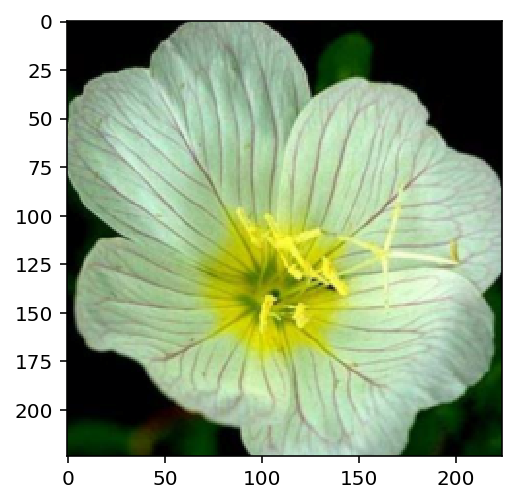

In [10]:
# This function provided by Udacity
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Test image processing
imshow(process_image("flowers/valid/1/image_06739.jpg"))


### Class Prediction

Finally, the full pipeline is complete: everything from inference to label-name mapping to results presentation can be combined, an image can be given as input, and a classification of the image can be expected as output.

In [11]:
# Accept imagepath and model, and return top-K of image
def predict(imagepath, model, k=5):
    
    # Process image into tensor
    image = process_image(imagepath)
    image = image.unsqueeze(0)
    
    # Change to evaluation mode
    model.eval()
    
    # Run image through model
    with torch.no_grad():
        
        # Send image and model to active device
        image.to("cpu")
        model.to("cpu")
        
        # Run image through model to get top-Ks
        log_probs = model(image)
        probs = torch.exp(log_probs)
        top_probs, top_classes = probs.topk(k, dim=1)
        
        # Convert top-K classes into label indices, and convert to lists
        idx_to_class = {val: key for key, val in model.class_to_idx.items()}
        class_list = [idx_to_class[i] for i in top_classes[0].tolist()]
        probs_list = top_probs[0].tolist()
        
        return probs_list, class_list
        

### Sanity Checking

It's wise to return more than just the highest *single* probability, however; because the added information can confirm how certain the network is about the classification it has made. For instance, in the following inference, there are strong runners-up, which means there's some signficant uncertainty:

<img src='images/inference.png' width="100%" height="auto" style="max-width: 800px;">

Now, let's see whether mine can do better...

['wild pansy', 'tree mallow', 'pink primrose', 'balloon flower', 'morning glory']
[0.9677202105522156, 0.014497778378427029, 0.008569423109292984, 0.008503802120685577, 0.0003488800139166415]


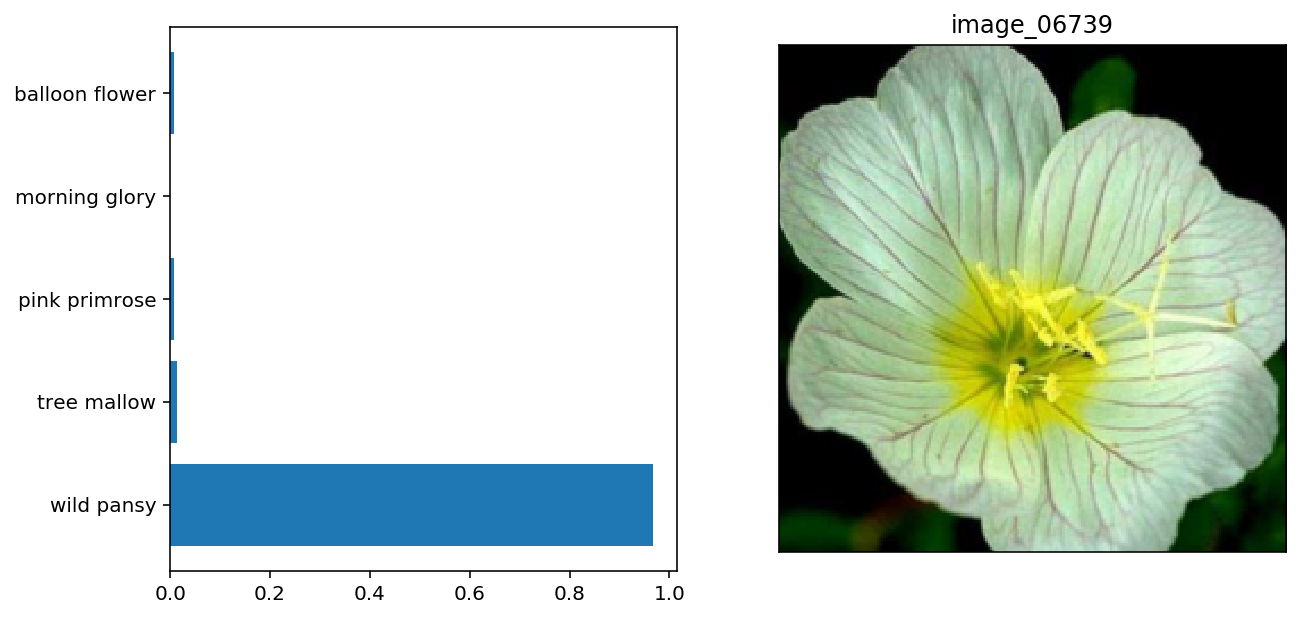

In [12]:
# Accept imagepath and model, and return top-K probabilities of its class
def classify(imagepath, model, k=5):
    
    # Predict classes
    probs, classes = predict(imagepath, model, k)
    
    # Get image name
    name = imagepath.split("/")[-1][0:-4]
    
    # Get flower names
    flowers = [class_to_name[str(i)] for i in classes]
    print(flowers)
    print(probs)
    
    # Create figure plot
    figure1, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
    
    # Add top-K subplot
    ax1.barh(flowers, probs)
    ax1.invert_yaxis()
    
    # Add image subplot
    ax2.set_title(name)
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    imshow(process_image(imagepath), ax2, name)
    
classify("flowers/valid/1/image_06739.jpg", load_model("checkpoint.pth"))


Booyah! That's a **wild pansy**, bay bee!  
Thank you for reading!

Made by <a href="https://github.com/SeanvonB">SeanvonB</a> | <a href="https://github.com/SeanvonB/image-classifier">Source</a>